In [1]:
#run this first!
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
options(repr.matrix.max.rows=10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Project Proposal: Optimized Classifier: Assessment of Regional Predictor Differences and Influence on Heart Disease Diagnoses  

### Introduction
The heart disease data includes datasets from Cleveland, California, Budapest, and Zurich. We will focus on Cleveland and Budapest because it is the most complete. Out of the 14 variables, 9 are categorical variables, variables that we can potentially predict by building a classifier.  

However, fasting blood pressure (fbs),  resting electrocardiographic results (restecg), the slope of the peak exercise ST segment (slope), number of major vessels (ca), reversible defect (thal) are objectively measured values and would be simpler to measure than predict.  

Predicting sex (sex) based on heart predictors diverges from the topic and could raise moral and ethical issues. Building a classifier to predict Chest pain type is not benefitial to the healthcare system, more on this through data visualizations in chest pain type frequency in Cleveland and Hungary bar plots.

CT scans to see potential blockages in arteries as a method of preventative care are avoided by public healthcare systems or costly with private healthcare. An accurate predictor could serve as a cheaper and more efficient alternative. There’s a dearth in understanding of whether optimal accuracy is achieved by building individual classifiers per region or by accumulating a large training set.

Preliminarily, numerical indicators include age, resting blood pressure(trestbps), serum cholesterol levels (chol), maximum heart rate achieved (thalach), and ST depression induced by exercise relative to rest (oldpeak). ST depression is a specific phenomenon on the ecg graph where a J-looking point goes below the baseline heart.

We will aim to answer the following research questions using numerical predictors:

1. Are all numerical predictors relevant to building an optimally accurate classifier? If not, which ones should we remove?
2. How does the frequency distribution of predictors change in Cleveland versus Hungary datasets?  
3. Do numerical predictions lead to different diagnoses in different regions? Would it be more beneficial to build a classifier per region or one giant classifier (via classifier accuracy analysis)?


## Preliminary Exploratory Data Analysis
### Reading, Tidying, and Wrangling Data

Firstly, we read two datasets(processed.cleveland.data & reprocessed.hungarian.data) directly from the web, gave every column a specific header name, selected the columns we are interested in, and converted every column into the correct and most appropriate data type. Then, all of the datasets are in a tidy format. 

Secondly, we split every dataset into a training set and a testing set with strata = num, ensuring that roughly the same proportion of 0 and 1(0 means no diagnosis; 1 means diagnosed) ends up in both training and testing sets. In the following steps, we will only analyze, summarize, and visualize the training sets of the two datasets.

In [2]:
set.seed(18)
con_names1<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang", "oldpeak","slope","ca","thal","num")
heart_cleveland<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = con_names1)

cleveland_mutate<-heart_cleveland|>
filter(num==0|num==1)|>
select(age,sex,cp,trestbps,chol,thalach,oldpeak,num)|>
mutate(age=as.integer(age))|>
mutate(num=as.factor(num))|>
mutate(cp=as.factor(cp))|>
mutate(sex=as.factor(sex))|>
mutate(trestbps=as.double(trestbps))|>
mutate(thalach=as.double(thalach))|>
mutate(oldpeak=as.double(oldpeak))

cleveland_split <- initial_split(cleveland_mutate, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

cleveland_training

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,thalach,oldpeak,num
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,150,2.3,0
37,1,3,130,250,187,3.5,0
41,0,2,130,204,172,1.4,0
56,1,2,120,236,178,0.8,0
57,0,4,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
67,1,3,152,212,150,0.8,1
63,0,4,124,197,136,0.0,1
57,0,4,140,241,123,0.2,1


In [3]:
set.seed(18)
heart_hungarian <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data",delim=" ", 
                              col_names = con_names1)
hungarian_mutate <- heart_hungarian|>
filter(num==0|num==1)|>
select(age,sex,cp,trestbps,chol,thalach,oldpeak,num)|>
mutate(age=as.integer(age))|>
mutate(num=as.factor(num))|>
mutate(cp=as.factor(cp))|>
mutate(sex=as.factor(sex))|>
mutate(trestbps=as.double(trestbps))|>
mutate(thalach=as.double(thalach))|>
mutate(oldpeak=as.double(oldpeak))



hungarian_split <- initial_split(hungarian_mutate, prop = 0.75, strata = num)
hungarian_training <- training(hungarian_split)
hungarian_testing <- testing(hungarian_split)

hungarian_training #print training data


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,thalach,oldpeak,num
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,1,2,140,289,172,0,0
37,1,2,130,283,98,0,0
54,1,3,150,-9,122,0,0
39,1,3,120,339,170,0,0
45,0,2,130,237,170,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
50,1,4,145,264,150,0.0,1
38,1,4,92,117,134,2.5,1
48,1,4,160,268,103,1.0,1


-------------------------------------------------------------------------------------------------------------------------------

### Summary of the five potential numerical variables for the two heart disease training datasets from Cleveland and Hungarian.

We summarized the five potential numerical predictors(age, trestbps, chol, thalach, & oldpeak). We obtained the means, maximums, and minimums formatted via tables. Each training dataset has two tables: one is summarized based on the whole dataset, and another one is summarized based on only individuals with heart disease, where num=1.

In [4]:
#Cleveland Summary for all individuals (max, min, mean)
cleveland_5predictors_all_summary<-summarize(cleveland_training,
                                        age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))
#Cleveland Summary for diagnosed individuals (max, min, mean)
cleveland_5predictors_diagnosed_summary<-summarize(cleveland_training|>filter(num==1),
                                        age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))

In [5]:
#Hungary Summary for all individuals (max, min, mean)
hungarian_5predictors_all_summary<-summarize(hungarian_training,
                                       age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))

#Hungary Summary for diagnosed individuals (max, min, mean)
hungarian_5predictors_diagnosed_summary<-summarize(hungarian_training|>filter(num==1),
                                      age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))

In [6]:
#Cleveland Summary for all individuals (max, min, mean)
cleveland_5predictors_all_summary

age_max,age_min,age_mean,trestbps_max,trestbps_min,trestbps_mean,chol_max,chol_min,chol_mean,thalach_max,thalach_min,thalach_mean,oldpeak_max,oldpeak_min,oldpeak_mean
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
76,29,52.55488,192,94,130.372,417,157,246,202,88,156.7927,4.2,0,0.6743902


In [7]:
#Hungary Summary for all individuals (max, min, mean)
hungarian_5predictors_all_summary

age_max,age_min,age_mean,trestbps_max,trestbps_min,trestbps_mean,chol_max,chol_min,chol_mean,thalach_max,thalach_min,thalach_mean,oldpeak_max,oldpeak_min,oldpeak_mean
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
65,28,46.94643,190,-9,130.8571,466,-9,220.5357,190,-9,143.375,3,0,0.2857143


The two tables above seem to have no significant differences in comparisons for each statistic except for some extreme values(such as the chol_min and the thalach_min from Hungarian). 

In [8]:
#Cleveland Summary for diagnosed individuals (max, min, mean)
cleveland_5predictors_diagnosed_summary

age_max,age_min,age_mean,trestbps_max,trestbps_min,trestbps_mean,chol_max,chol_min,chol_mean,thalach_max,thalach_min,thalach_mean,oldpeak_max,oldpeak_min,oldpeak_mean
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
70,35,55.39024,192,108,134.1951,335,172,251.2195,195,88,146.6585,3.6,0,0.9121951


In [9]:
#Hungary Summary for diagnosed individuals (max, min, mean)
hungarian_5predictors_diagnosed_summary

age_max,age_min,age_mean,trestbps_max,trestbps_min,trestbps_mean,chol_max,chol_min,chol_mean,thalach_max,thalach_min,thalach_mean,oldpeak_max,oldpeak_min,oldpeak_mean
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
65,31,46.92593,160,92,129.1111,466,117,242.8519,180,87,139.6296,3,0,0.9074074


Looking at all four tables above, there are some slight differences, but we still cannot obtain any meaningful conclusions; maybe we can discover something later. Let's move to the visualizations. 

-------------------------------------------------------------------------------------------------------------------------------

### Visualizations of the seven potential predictor variables for Cleveland and Hungarian

Two of the seven potential variables are categorical(cp & sex), and the other five are numerical(age, trestbps, chol, thalach,& oldpeak). Although categorical variables are not appropriate for building classifiers, they can help show differences in the distributions of variables in the two regions if differences exist. Making bar plots is an excellent way to show the distributions of categorical variables, and making histograms is the most appropriate way for numerical variables, so we did!

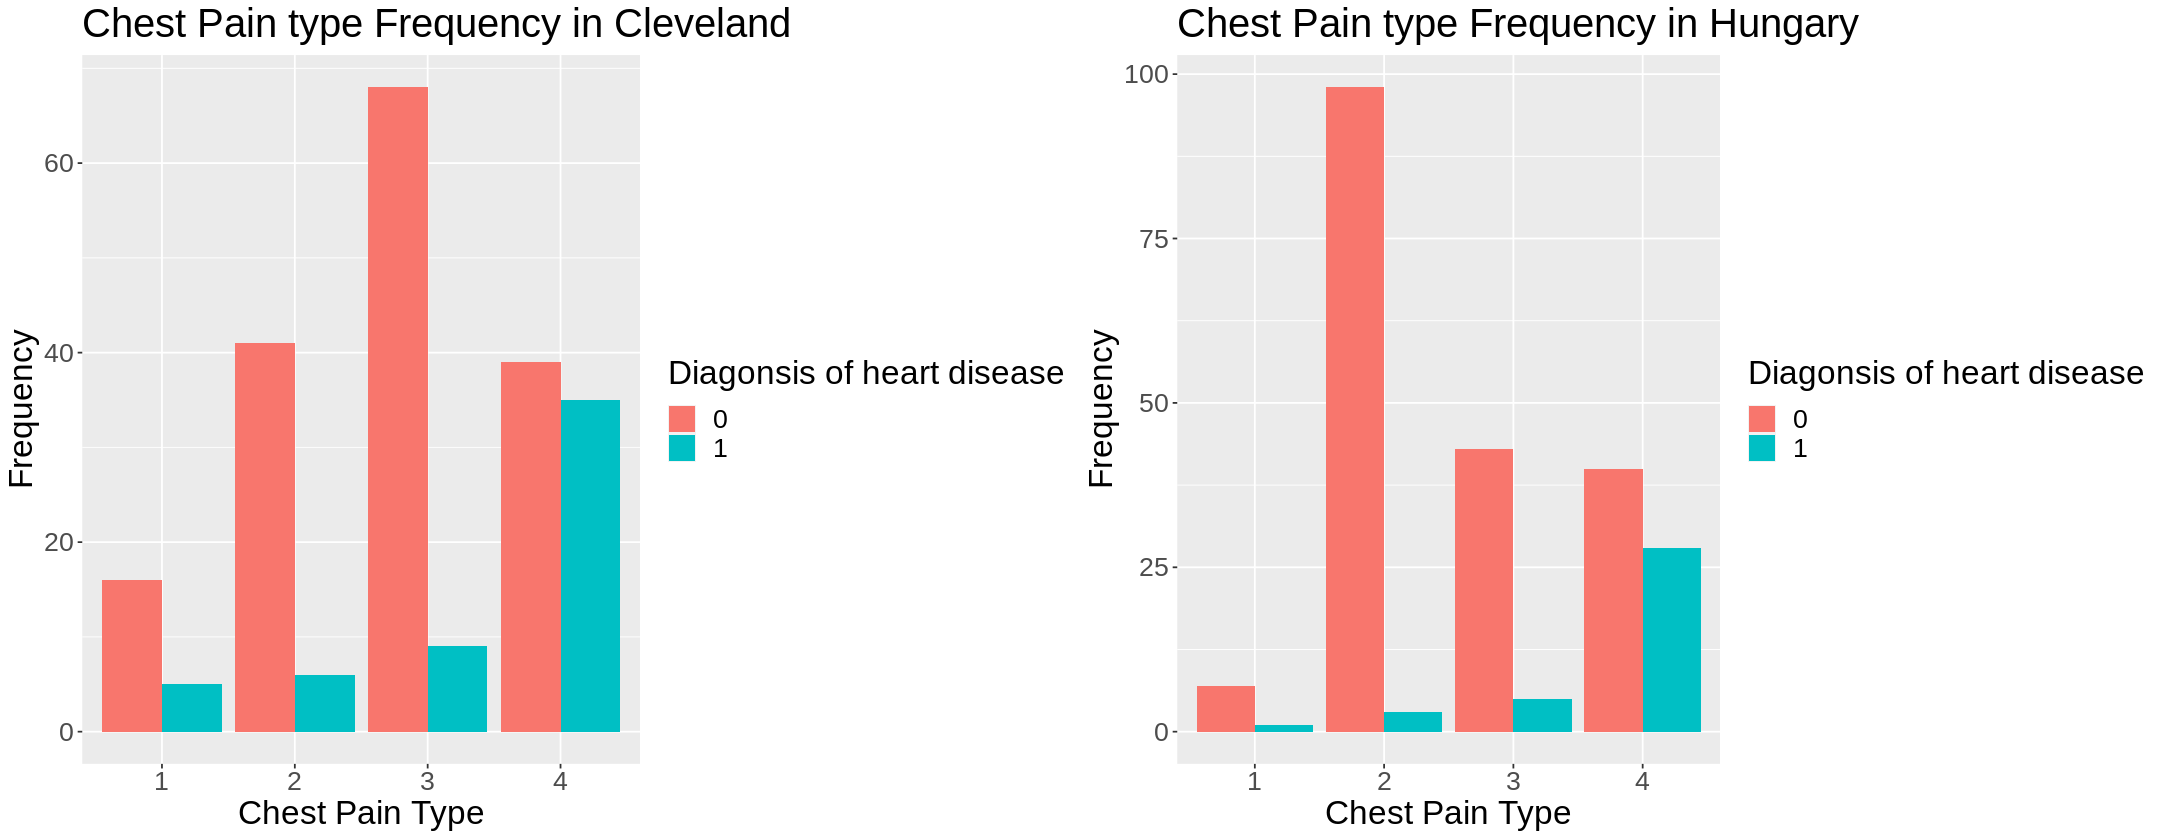

In [10]:
options(repr.plot.width=18, repr.plot.height=7)
cp_num_cleveland<-cleveland_mutate|>
ggplot(aes(x=cp,fill= num))+
geom_bar(position="dodge")+
labs(x="Chest Pain Type",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Chest Pain type Frequency in Cleveland")+
theme(text=element_text(size=20))


cp_num_hungarian<-hungarian_mutate|>
ggplot(aes(x=cp,fill= num))+
geom_bar(position="dodge")+
labs(x="Chest Pain Type",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Chest Pain type Frequency in Hungary")+
theme(text=element_text(size=20))

#Compares cp frequency for 2 regions
plot_grid(cp_num_cleveland, cp_num_hungarian, ncol = 2)

X axis definition:
1 -> typical angina
2 -> atypical angina
3 -> non-anginal pain
4 -> asymptomatic 

Legend Definition
0 -> no heart diseaase
1 -> heaart diseaase

Chest pain type's distribution shifted to the left relative to Cleveland; this opens an investigation into whether regional differences in frequency affect an accurate diagnosis by the classifier. And whether a classifier built for a specific region is more appropriate. 

Chest pain type (cp)  has weakly predicted potential heart disease as blue (heart disease bars are much shorter than pink diagnosis bars. 

If there's no chest pain (i.e., asymptomatic), the probability of heart disease is greater.

A classifier predicting cp will only engender fear and divert healthcare resources to individuals not in need and thus hinder the efficiency of more urgent situations.

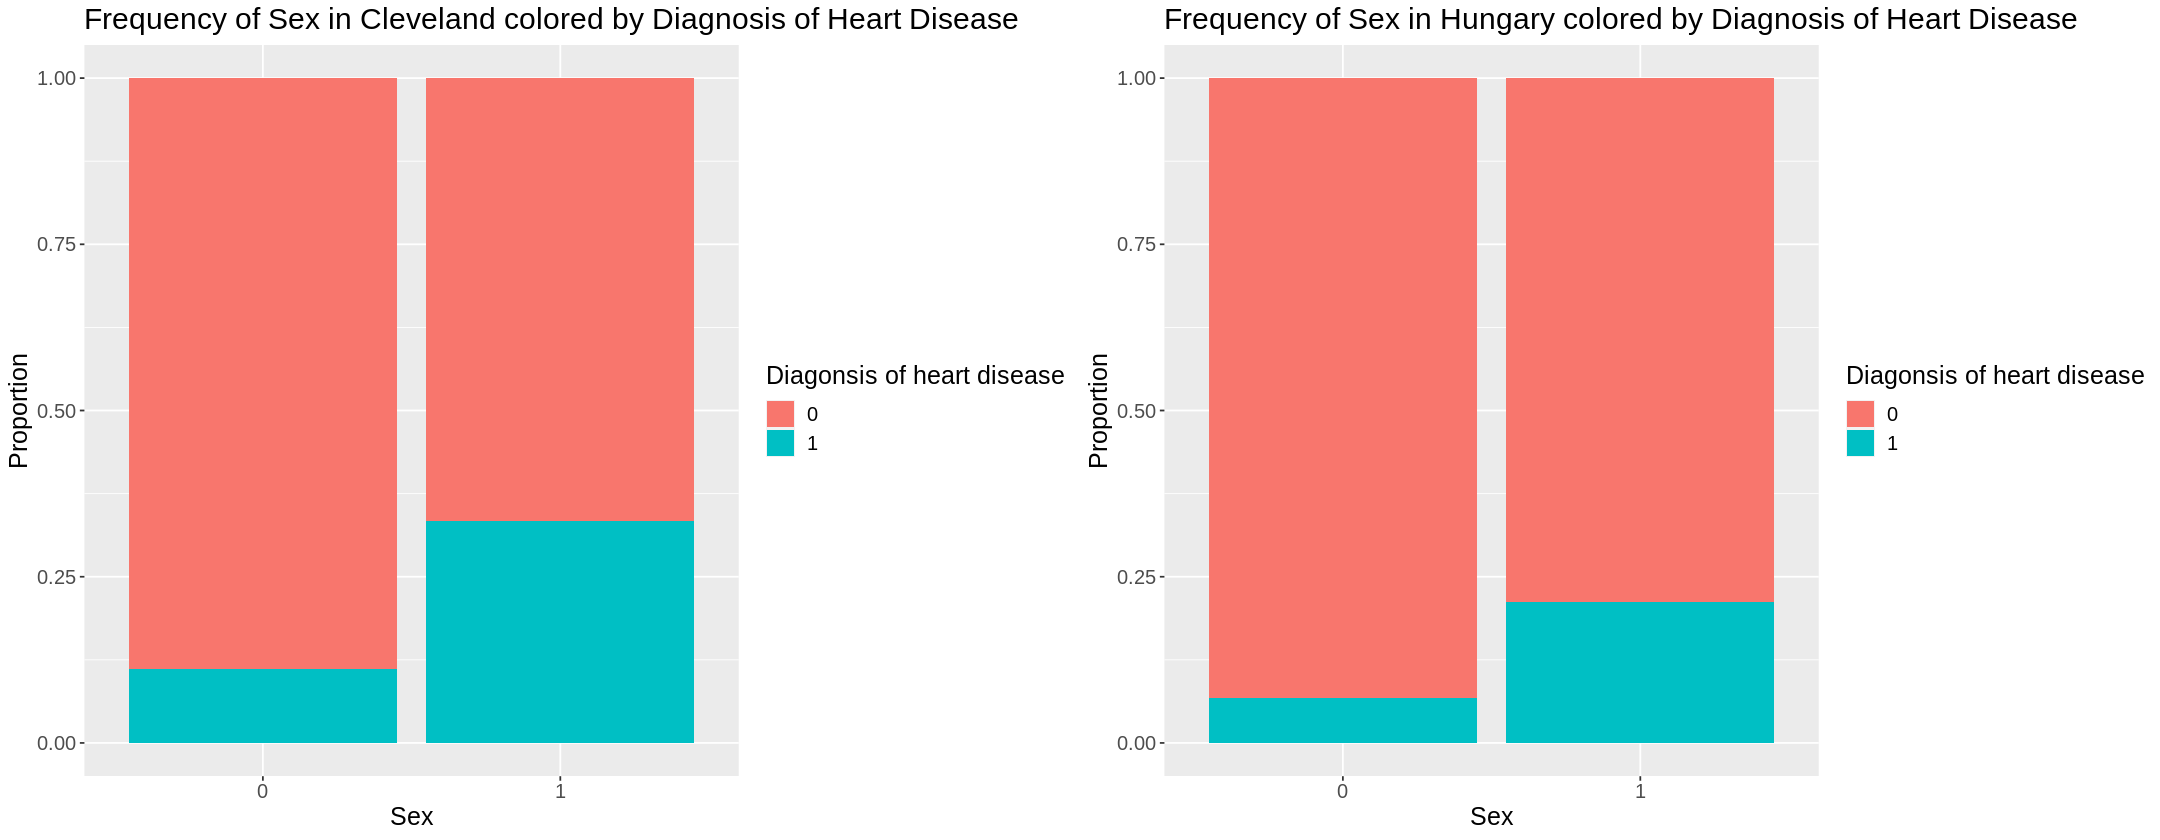

In [40]:
options(repr.plot.width=18, repr.plot.height=7)
sex_num_cleveland<-cleveland_mutate|>
ggplot(aes(x=sex,fill= num))+
geom_bar(position="fill")+
labs(x="Sex",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Frequency of Sex in Cleveland colored by Diagnosis of Heart Disease")+
theme(text=element_text(size=15))


sex_num_hungarian<-hungarian_mutate|>
ggplot(aes(x=sex,fill= num))+
geom_bar(position="fill")+
labs(x="Sex",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Frequency of Sex in Hungary colored by Diagnosis of Heart Disease")+
theme(text=element_text(size=15))

#Compares sex frequency for 2 regions
plot_grid(sex_num_cleveland, sex_num_hungarian, ncol = 2)

Legend labels (0 = no heart disease, 1 = heart disease present)

Some diseases are more common in one sex over another, such as red-green colorblindness is more common in men. 1 (male) on the x-axis has a ~30% and ~20% diagnosis rate of heart disease in Cleveland and Hungary, respectively. Whereas 0 on the x-axis (female) has lower relative rates, ~12%, and ~6%, in Cleveland and Hungary, respectively. Preliminary plotting indicates gender could be a potential predictor contributing to the accuracy of the data.

Warning message:
“Removed 18 rows containing missing values (geom_bar).”


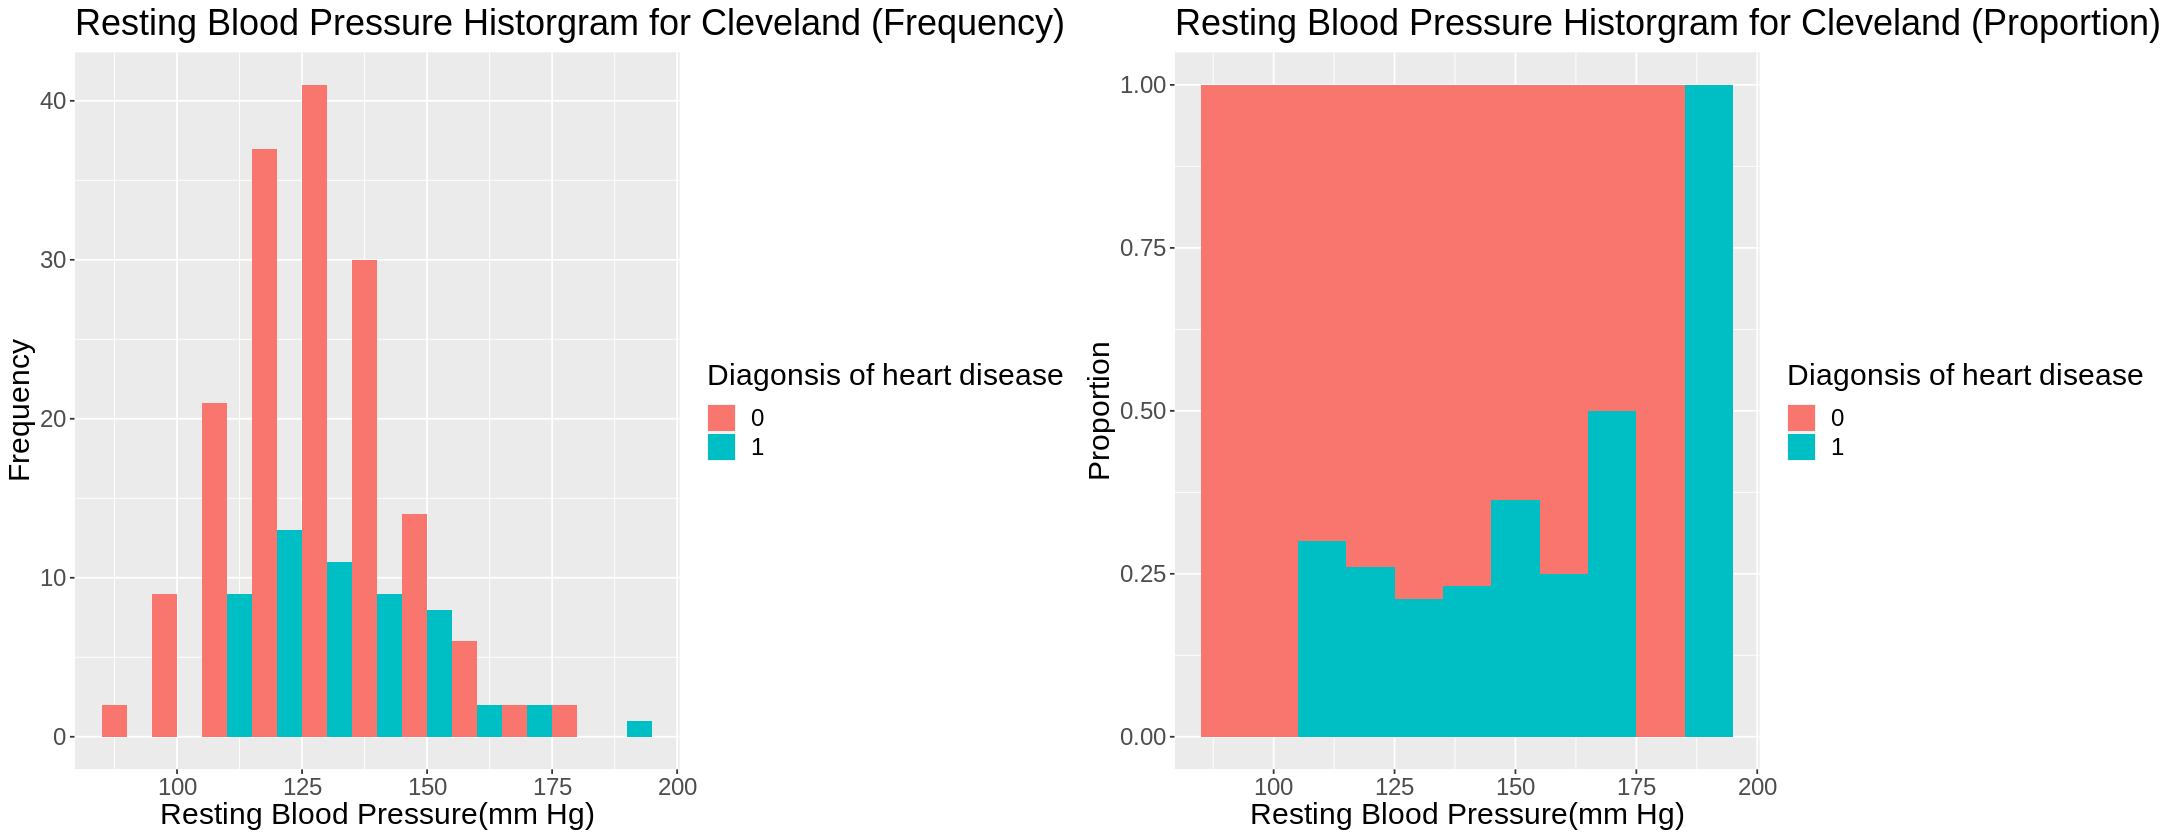

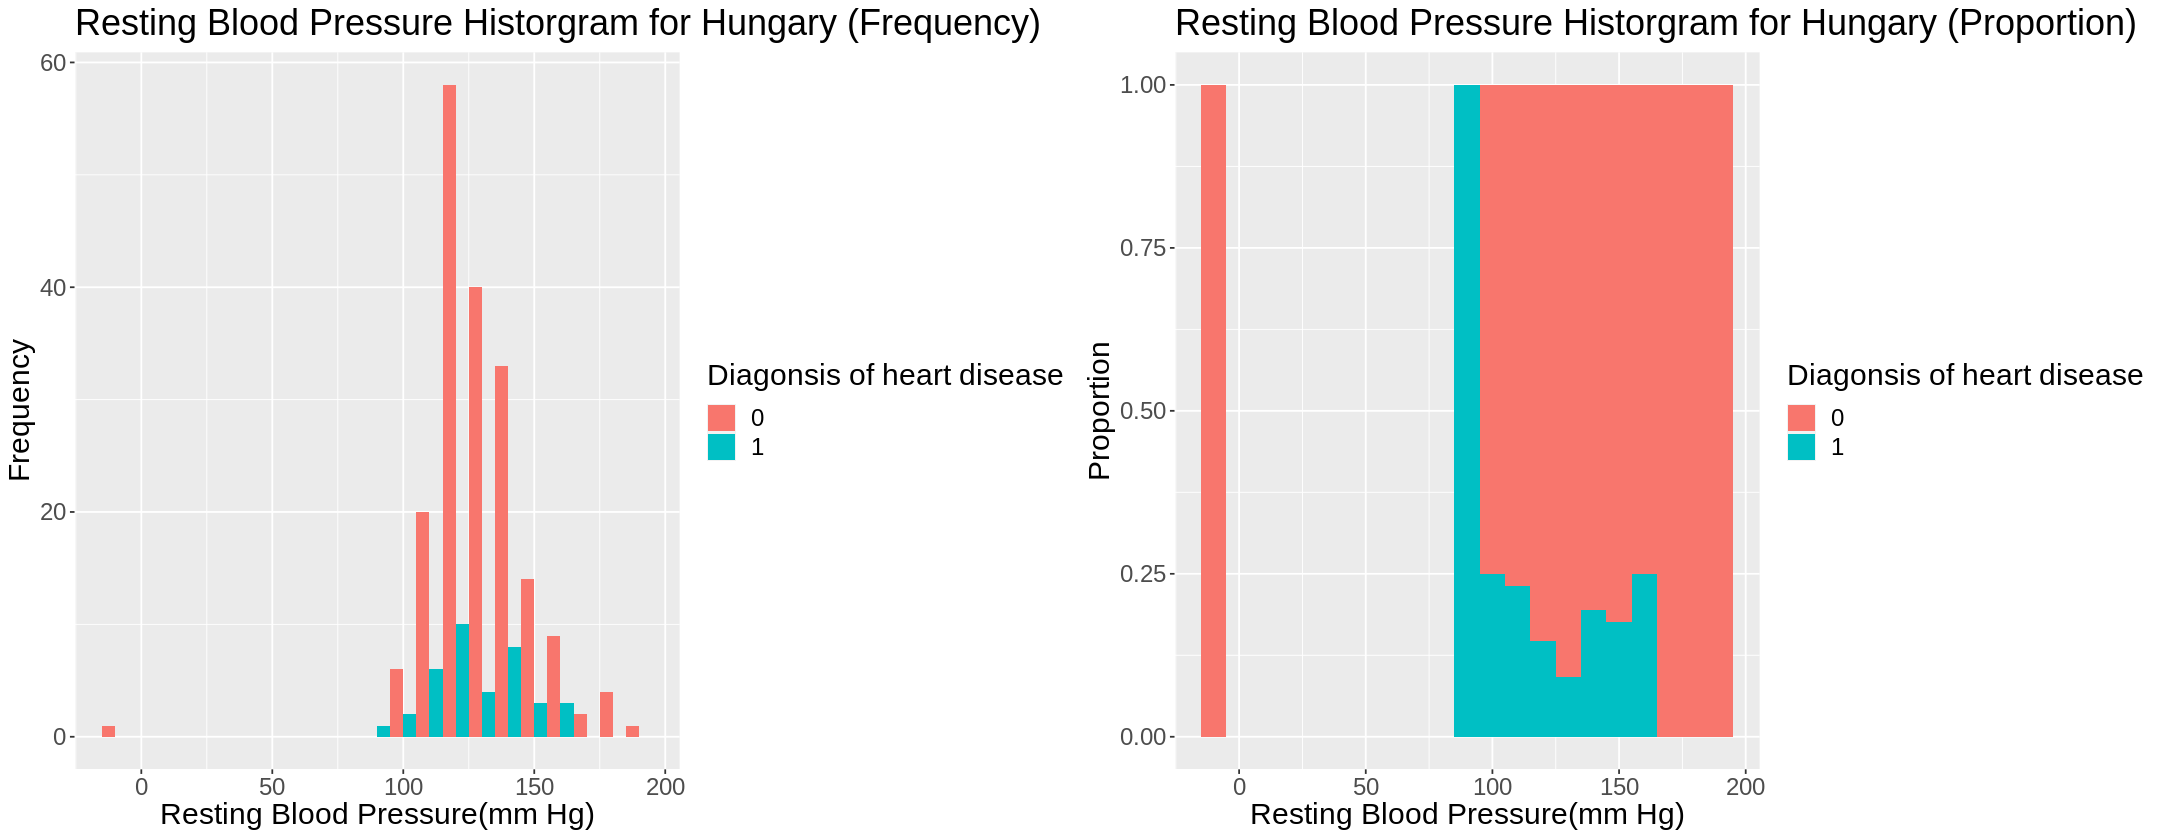

In [29]:
trestbps_num_cleveland_f<-cleveland_mutate|>
ggplot(aes(x=trestbps,fill= num))+
geom_histogram(position="dodge",binwidth=10)+
labs(x="Resting Blood Pressure(mm Hg)",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Resting Blood Pressure Historgram for Cleveland (Frequency)")+
theme(text=element_text(size=18))

trestbps_num_cleveland_p<-cleveland_mutate|>
ggplot(aes(x=trestbps,fill= num))+
geom_histogram(position="fill",binwidth=10)+
labs(x="Resting Blood Pressure(mm Hg)",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Resting Blood Pressure Historgram for Cleveland (Proportion)")+
theme(text=element_text(size=18))

trestbps_num_hungarian_f<-hungarian_mutate|>
ggplot(aes(x=trestbps,fill= num))+
geom_histogram(position="dodge",binwidth=10)+
labs(x="Resting Blood Pressure(mm Hg)",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Resting Blood Pressure Historgram for Hungary (Frequency)")+
theme(text=element_text(size=18))

trestbps_num_hungarian_p<-hungarian_mutate|>
ggplot(aes(x=trestbps,fill= num))+
geom_histogram(position="fill",binwidth=10)+
labs(x="Resting Blood Pressure(mm Hg)",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Resting Blood Pressure Historgram for Hungary (Proportion)")+
theme(text=element_text(size=18))

plot_grid(trestbps_num_cleveland_f, trestbps_num_cleveland_p, ncol = 2)
plot_grid(trestbps_num_hungarian_f, trestbps_num_hungarian_p, ncol = 2)

There seems to be an outlier in the Hungary dataset where -9 blood pressure is likely impossible. When ignoring the outlier, the frequency distribution in resting blood pressure is fairly similar.  

When looking at the proportions (right), Cleveland shows extremely high resting blood pressure ~185-195 resulting in a 100% diagnosis of heart disease. Contrastly, the Hungary training dataset shows a 100% heart disease diagnosis rate of ~75 to 85 mm Hg.  This indicates potential regional differences in predictors predicting heart disease, and we will consider this when building classifiers. However, when we do not look at 100% diagnosed values in resting blood pressure, both bar graphs are at around 20% to 25%, with Cleveland closer to 25% and Hungary closer to 20%.

Warning message:
“Removed 8 rows containing missing values (geom_bar).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”


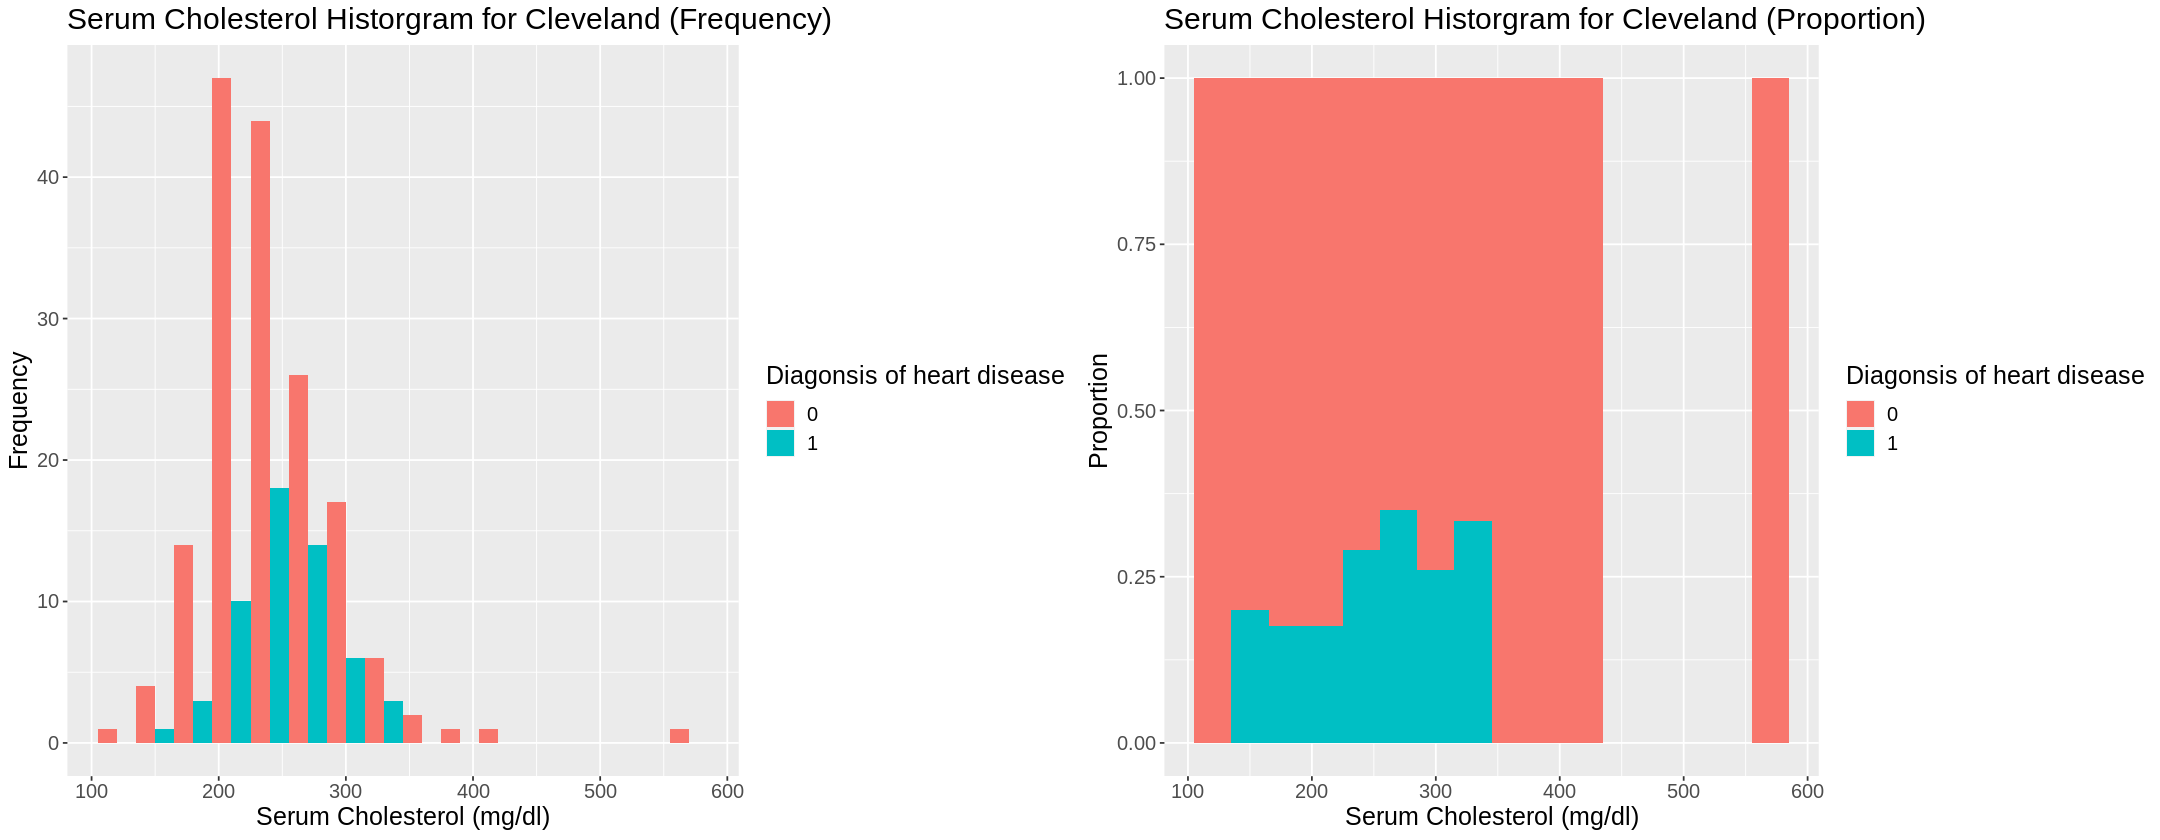

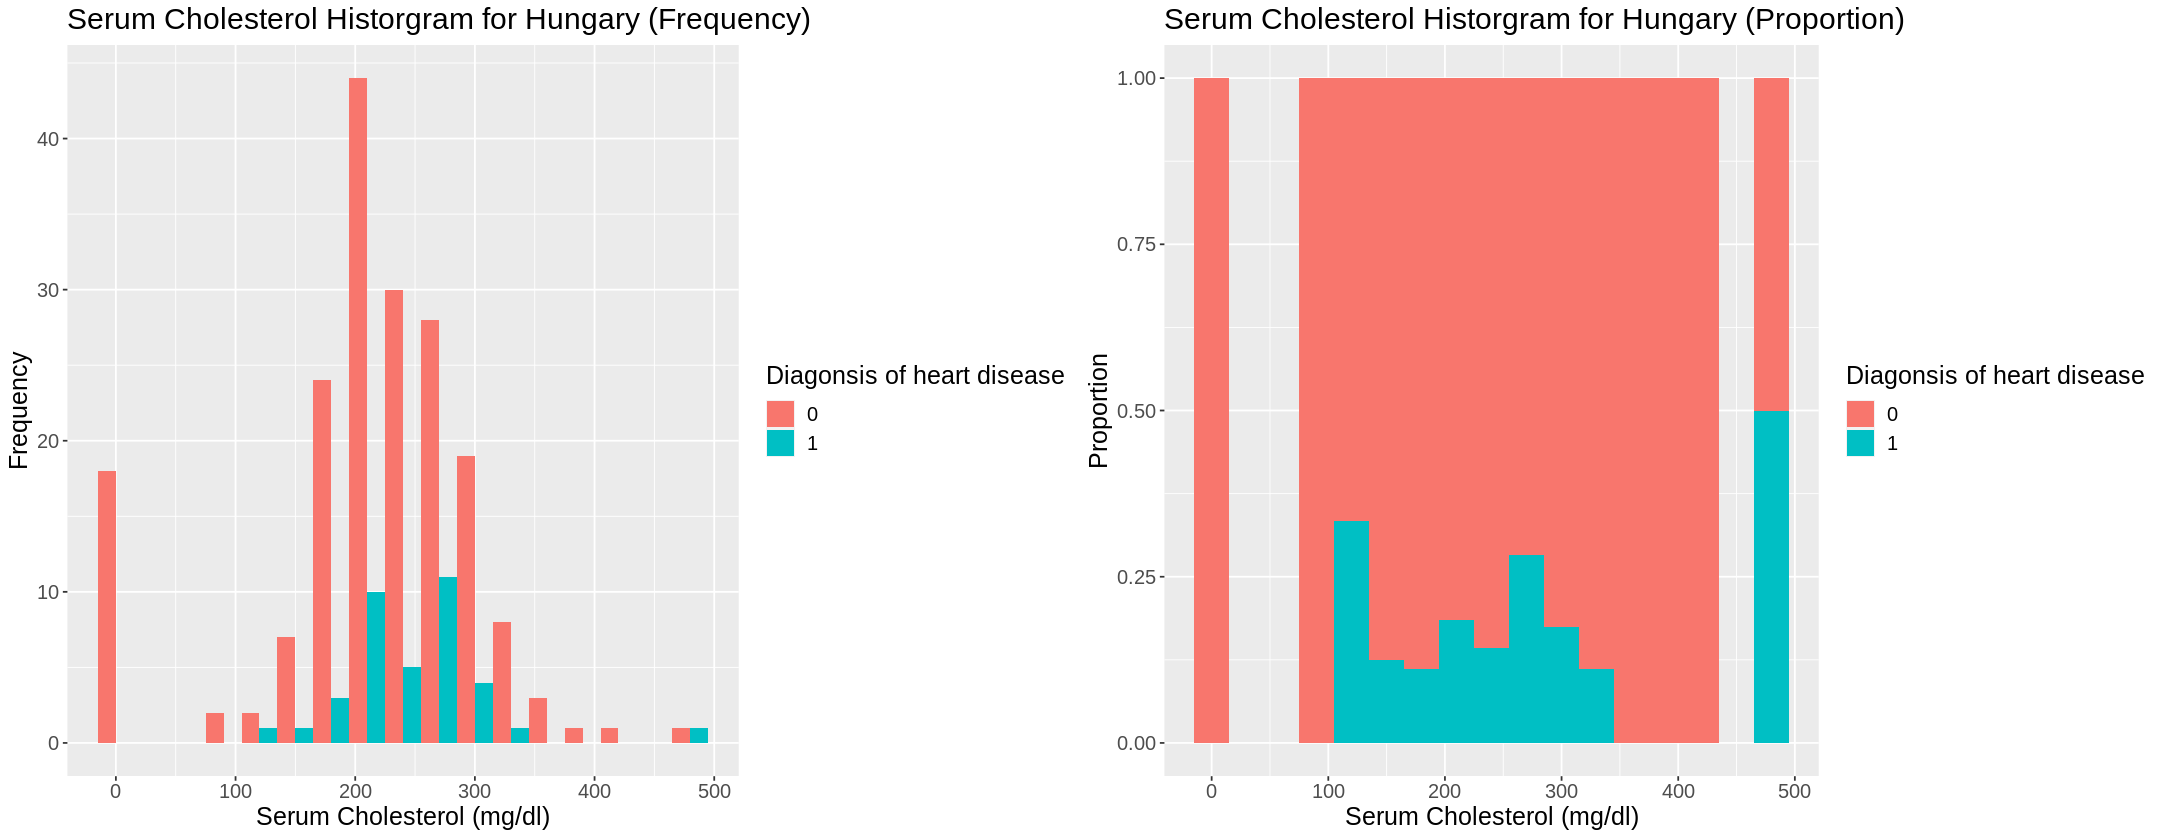

In [32]:
chol_num_cleveland_f<-cleveland_mutate|>
ggplot(aes(x=chol,fill= num))+
geom_histogram(position="dodge",binwidth=30)+
labs(x="Serum Cholesterol (mg/dl)",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Serum Cholesterol Historgram for Cleveland (Frequency)")+
theme(text=element_text(size=15))

chol_num_cleveland_p<-cleveland_mutate|>
ggplot(aes(x=chol,fill= num))+
geom_histogram(position="fill",binwidth=30)+
labs(x="Serum Cholesterol (mg/dl)",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Serum Cholesterol Historgram for Cleveland (Proportion)")+
theme(text=element_text(size=15))

chol_num_hungarian_f<-hungarian_mutate|>
ggplot(aes(x=chol,fill= num))+
geom_histogram(position="dodge",binwidth=30)+
labs(x="Serum Cholesterol (mg/dl)",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Serum Cholesterol Historgram for Hungary (Frequency)")+
theme(text=element_text(size=15))

chol_num_hungarian_p<-hungarian_mutate|>
ggplot(aes(x=chol,fill= num))+
geom_histogram(position="fill",binwidth=30)+
labs(x="Serum Cholesterol (mg/dl)",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Serum Cholesterol Historgram for Hungary (Proportion)")+
theme(text=element_text(size=15))

plot_grid(chol_num_cleveland_f, chol_num_cleveland_p, ncol = 2)
plot_grid(chol_num_hungarian_f, chol_num_hungarian_p, ncol = 2)

Histogram plot mimics bell curve.  The distribution of cholesterol is similar when excluding the outlier.

The proportion histogram indicates that the distribution of diagnosed individuals relative to the total is bimodal (M-shaped) for Hungary.  However, Cleveland indicates a unimodal distribution (n-shaped).   This also indicates potential regional differences in predictors predicting heart disease, and we will consider this when building classifiers.

Warning message:
“Removed 4 rows containing missing values (geom_bar).”


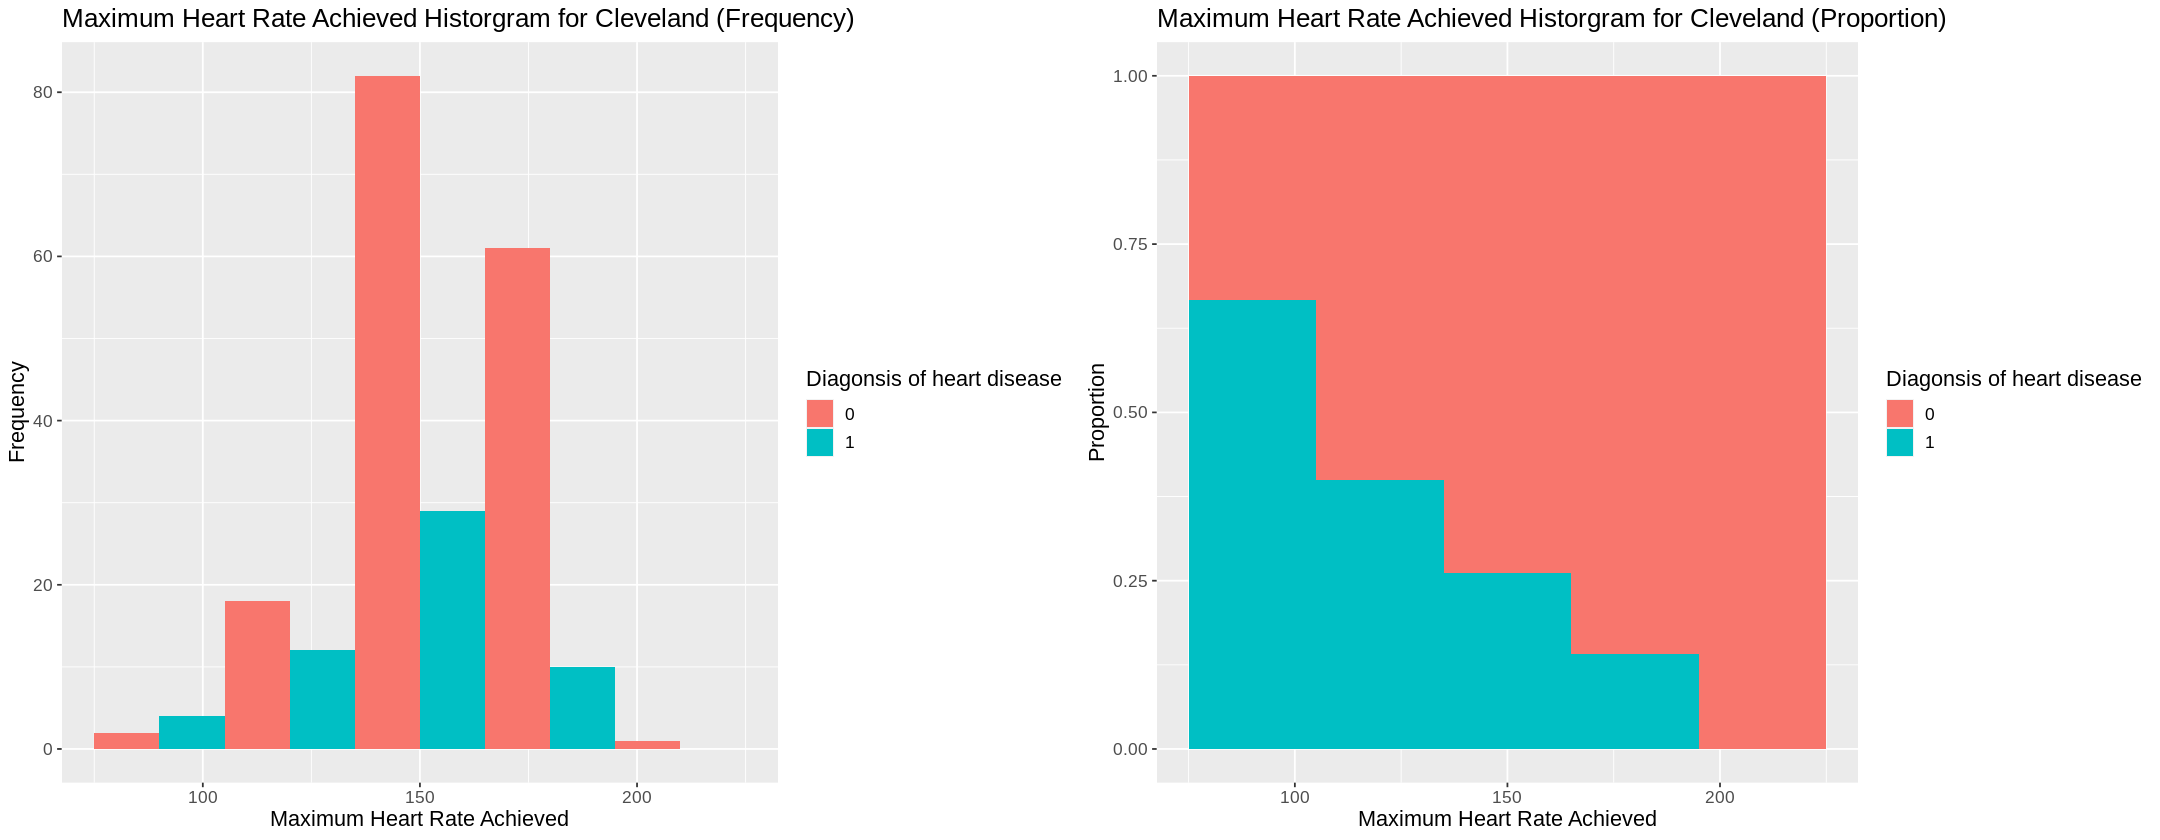

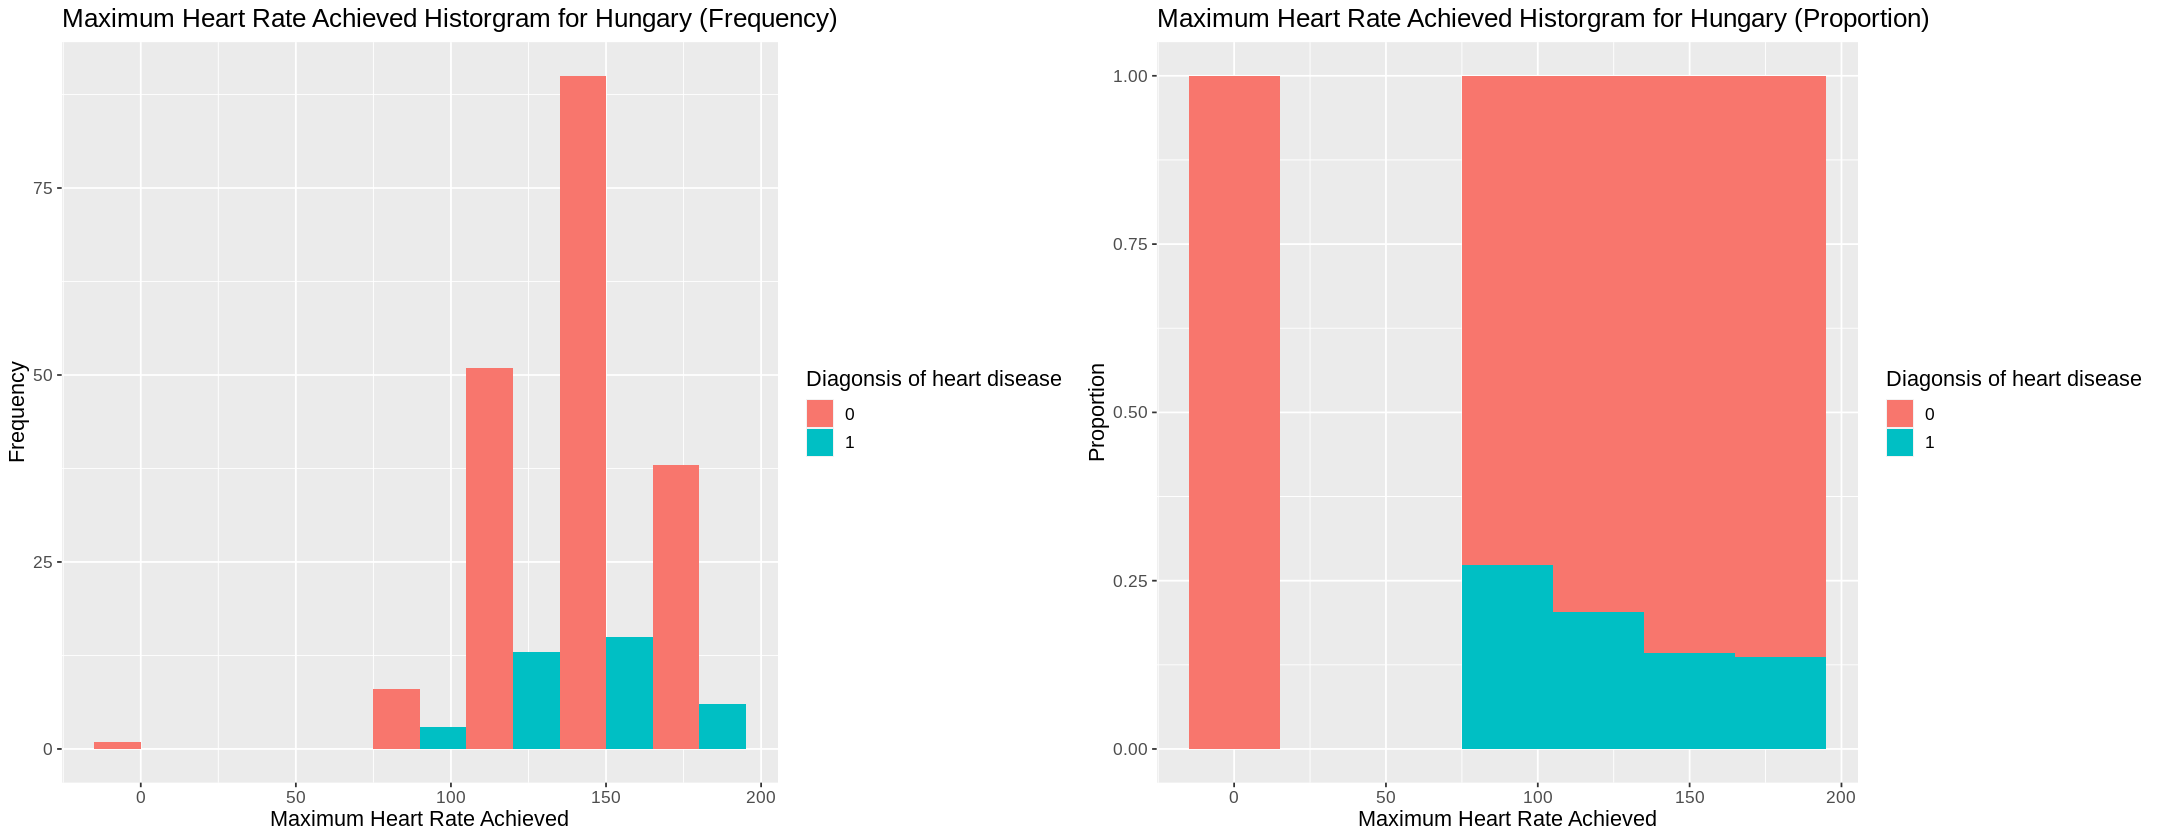

In [34]:
thalach_num_cleveland_f<-cleveland_mutate|>
ggplot(aes(x=thalach,fill= num))+
geom_histogram(position="dodge",binwidth=30)+
labs(x="Maximum Heart Rate Achieved",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Maximum Heart Rate Achieved Historgram for Cleveland (Frequency)")+
theme(text=element_text(size=13))


thalach_num_cleveland_p<-cleveland_mutate|>
ggplot(aes(x=thalach,fill= num))+
geom_histogram(position="fill",binwidth=30)+
labs(x="Maximum Heart Rate Achieved",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Maximum Heart Rate Achieved Historgram for Cleveland (Proportion)")+
theme(text=element_text(size=13))

thalach_num_hungarian_f<-hungarian_mutate|>
ggplot(aes(x=thalach,fill= num))+
geom_histogram(position="dodge",binwidth=30)+
labs(x="Maximum Heart Rate Achieved",y="Frequency",fill="Diagonsis of heart disease")+
ggtitle("Maximum Heart Rate Achieved Historgram for Hungary (Frequency)")+
theme(text=element_text(size=13))


thalach_num_hungarian_p<-hungarian_mutate|>
ggplot(aes(x=thalach,fill= num))+
geom_histogram(position="fill",binwidth=30)+
labs(x="Maximum Heart Rate Achieved",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("Maximum Heart Rate Achieved Historgram for Hungary (Proportion)")+
theme(text=element_text(size=13))

plot_grid(thalach_num_cleveland_f, thalach_num_cleveland_p, ncol = 2)
plot_grid(thalach_num_hungarian_f, thalach_num_hungarian_p, ncol = 2)

The maximum heart rate achieved indicated similar distributions in both regions. Both regions indicated a decrease in maximum heart rate increased proportion of individuals diagnosed with heart disease. Therefore, it could be a good predictor. The proportion of diagnosed individuals in Cleveland is higher than in Hungary. That also is what we need to consider when building classifiers.

Warning message:
“Removed 24 rows containing missing values (geom_bar).”
Warning message:
“Removed 46 rows containing missing values (geom_bar).”


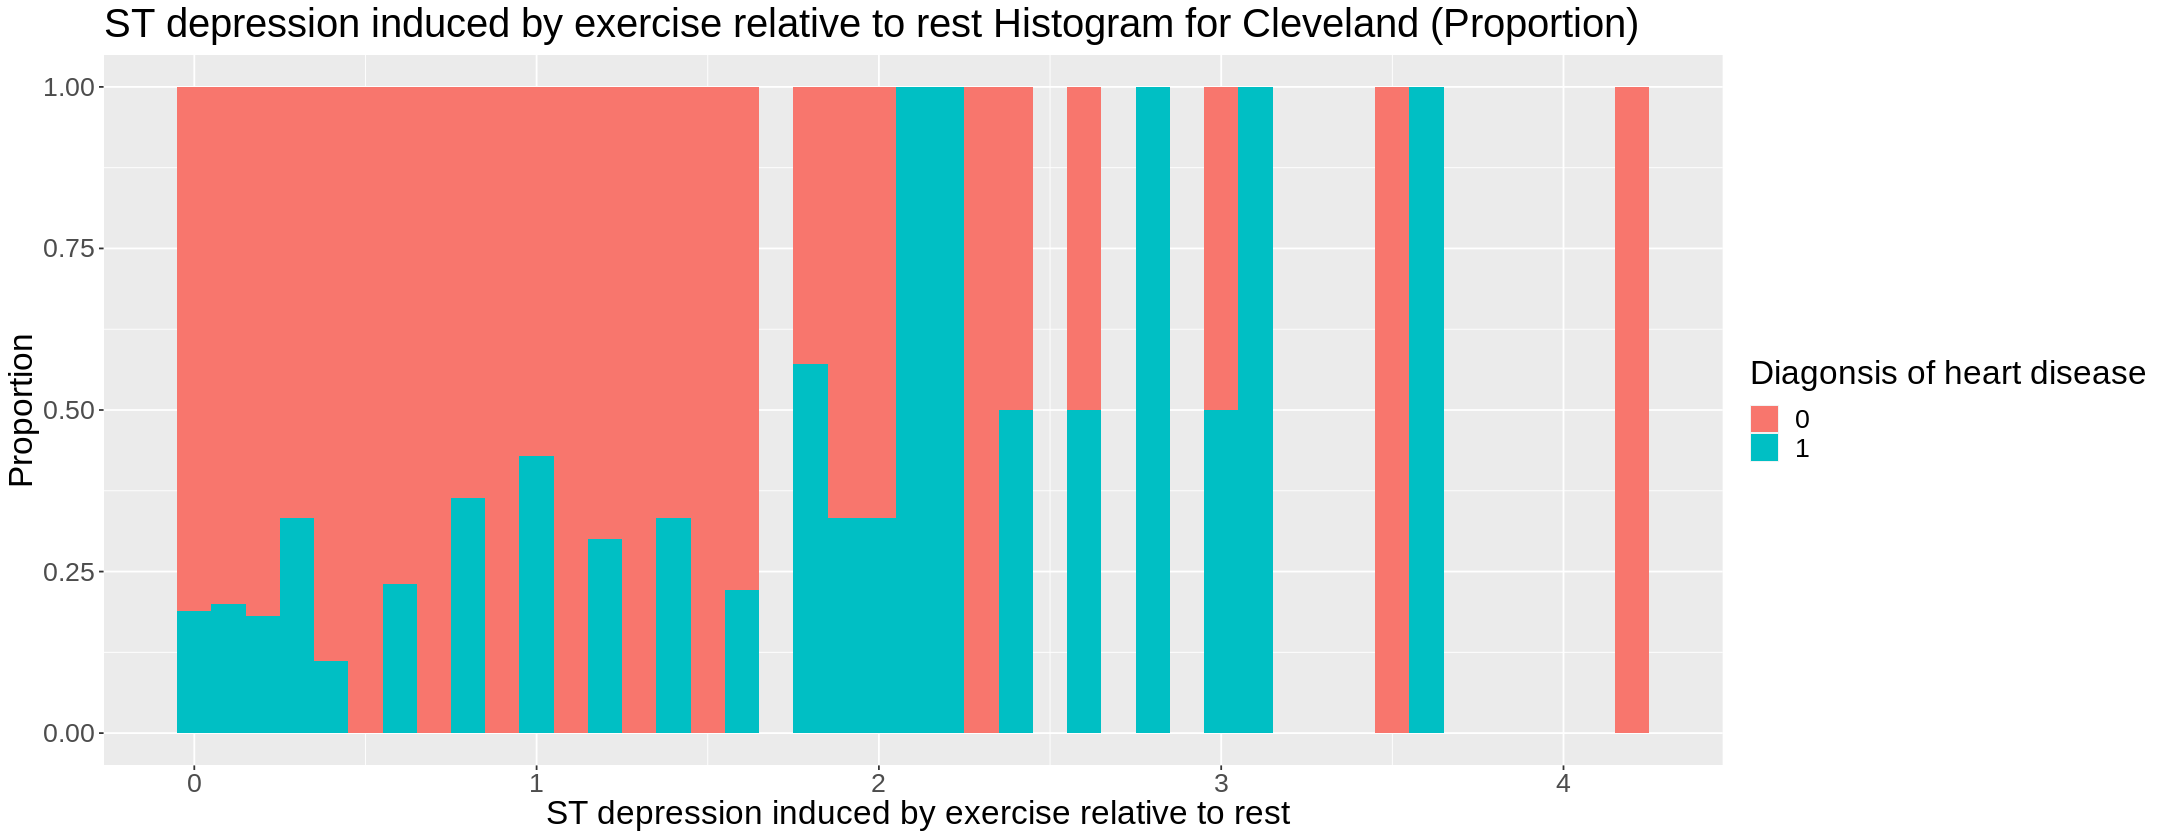

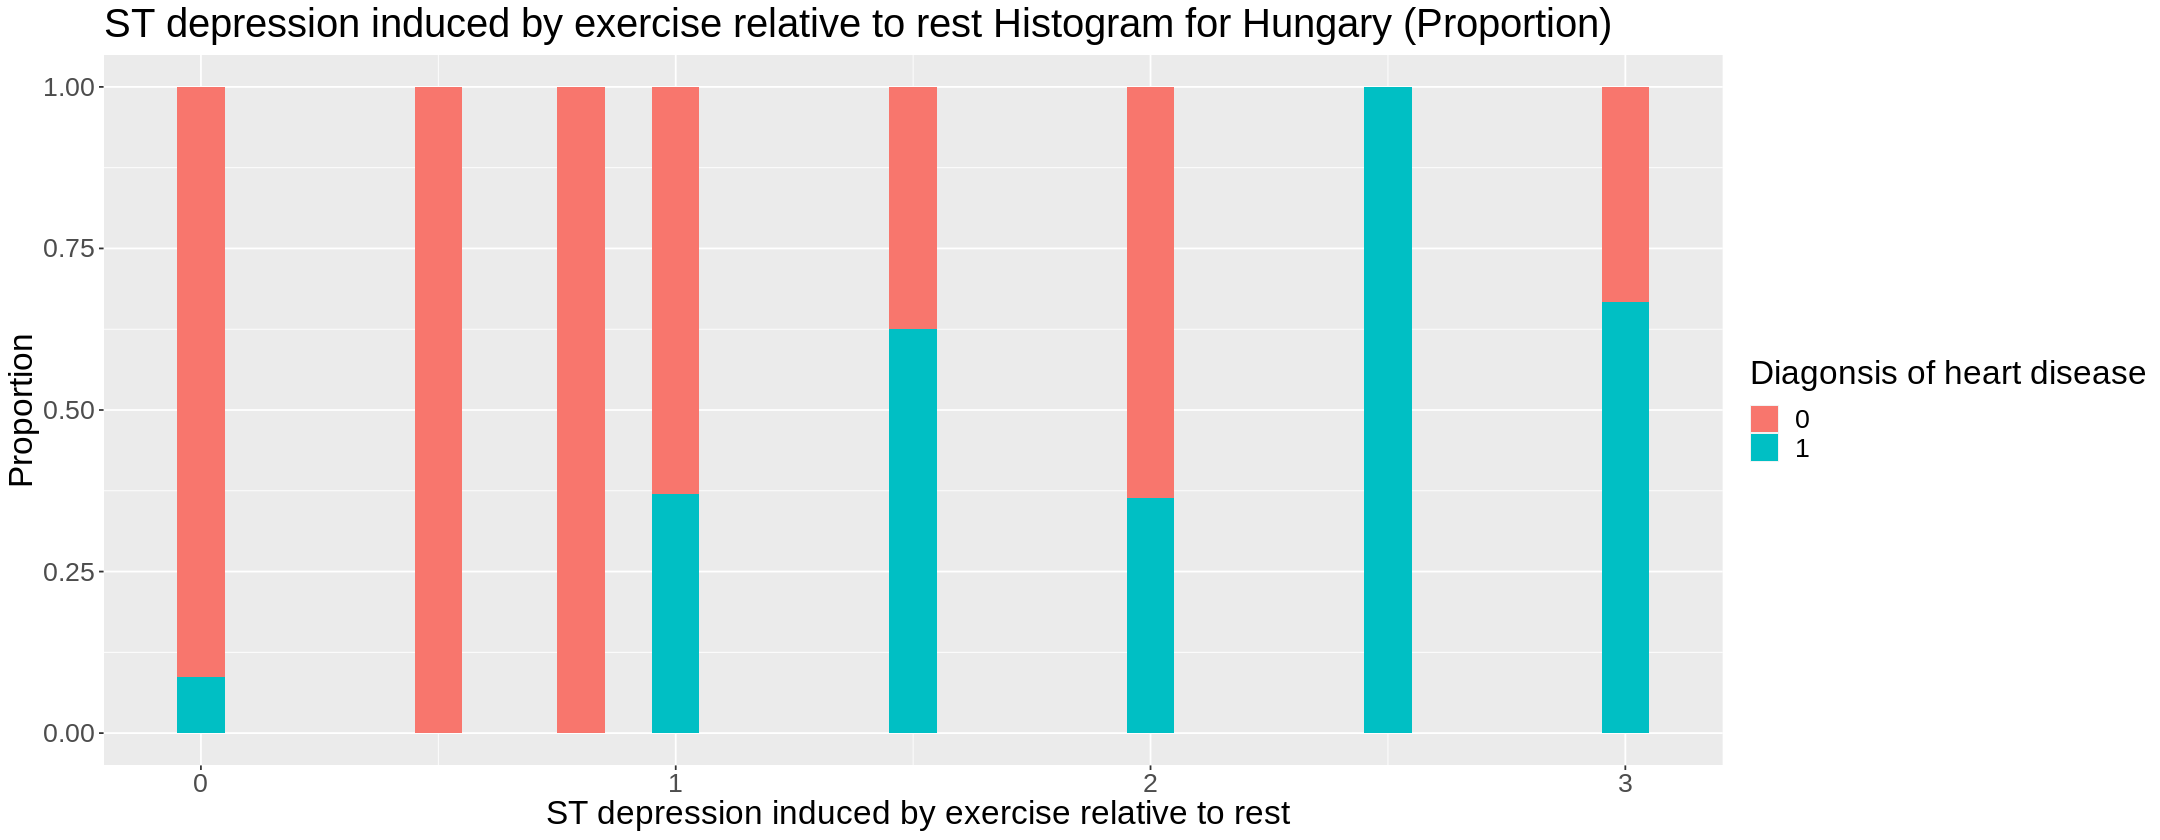

In [38]:
oldpeak_num_cleveland_p<-cleveland_mutate|>
ggplot(aes(x=oldpeak,fill= num))+
geom_histogram(position="fill",binwidth=0.1)+
labs(x=" ST depression induced by exercise relative to rest",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("ST depression induced by exercise relative to rest Histogram for Cleveland (Proportion)")+
theme(text=element_text(size=20))
oldpeak_num_cleveland_p

oldpeak_num_hungarian_p<-hungarian_mutate|>
ggplot(aes(x=oldpeak,fill= num))+
geom_histogram(position="fill",binwidth=0.1)+
labs(x=" ST depression induced by exercise relative to rest",y="Proportion",fill="Diagonsis of heart disease")+
ggtitle("ST depression induced by exercise relative to rest Histogram for Hungary (Proportion)")+
theme(text=element_text(size=20))
oldpeak_num_hungarian_p

When ST depression induced by exercise relative to rest increases, the proportion of individuals diagnosed with heart disease also increases. Slight differences in distribution could affect the accuracy of the classifier.

## Methods
 
Building on the methodology touched upon in the introduction and visualization, and we will do these in the following steps:

1. Building classifiers with optimal accuracy using v=5 cross-validation.
a. Per city ( Budapest (in Hungary), Cleveland, might add more cities to solidify conclusion) 
b. The large classifier with Budapest (in Hungary) and Cleveland with all predictors, and 1 for each predictor.

2. Compare the v=5 cross-folded accuracy of the different classifiers. Assess if changes hindered or benefited the classifier. 
3. Look at how predictors have changed across regions and assess if a region-specific classifier or a cumulative training set classifier is more accurate.


## Expected outcomes and significance:
### What do you expect to find?
It is expected that different regions will have different predictors predicting if new observations are diagnosed with heart disease or not. We hypothesize that classifiers should be region specific to optimize accuracy. On top of numerical predictors, which we found to be appropriate, sex also could be a relevant predictor.

### What impact could such findings have?
An accurate classifier could ease the healthcare system and improve efficiency by distributing healthcare personnel to more urgent situations. It could also create a cheaper alternative for government and private healthcare systems.

### What future questions could this lead to?
Preliminary data already indicated that a higher maximum heart rate leads to lower chances of heart disease. Methods to maximize heart rate could be a research question that stems from preventative methods. With more healthy individuals, there will be a less exhausted healthcare system.  

Moreover, more data could be collected on if external factors such as environmental, economical, political, and social could affect current predictors in this classifier.



